# TP2 Módulo 2: Apache Spark
## Ejercicio 1
## Jorge Pablo Ávila Gómez

# PARTE 1: Uso de Spark para análisis de datos, Dataframes #

In [1]:
# Mostrar la versión de Spark usada

# Datos de la sesión spark
spark

In [2]:
# Cargar el dataset en un Dataframe
data = spark.read.csv(
    "../RecursosdelTema2.2/dataset_descriptor.csv",
    mode="DROPMALFORMED",
    inferSchema=True,
    header=True,
)

In [3]:
# Mostrar el schema heredado
data.printSchema()

root
 |-- ip_proto: double (nullable = true)
 |-- ip_len_mean: double (nullable = true)
 |-- ip_len_median: double (nullable = true)
 |-- ip_len_var: double (nullable = true)
 |-- ip_len_std: double (nullable = true)
 |-- ip_len_entropy: double (nullable = true)
 |-- ip_len_cv: double (nullable = true)
 |-- ip_len_cvq: double (nullable = true)
 |-- ip_len_rte: double (nullable = true)
 |-- ip_ttl_mean: double (nullable = true)
 |-- ip_ttl_median: double (nullable = true)
 |-- ip_ttl_var: double (nullable = true)
 |-- ip_ttl_std: double (nullable = true)
 |-- ip_ttl_entropy: double (nullable = true)
 |-- ip_ttl_cv: double (nullable = true)
 |-- ip_ttl_cvq: double (nullable = true)
 |-- ip_ttl_rte: double (nullable = true)
 |-- sport_mean: double (nullable = true)
 |-- sport_median: double (nullable = true)
 |-- sport_var: double (nullable = true)
 |-- sport_std: double (nullable = true)
 |-- sport_entropy: double (nullable = true)
 |-- sport_cv: double (nullable = true)
 |-- sport_cvq: 

In [4]:
# Mostrar el número de registros del dataset
data.count()

45500

In [5]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
data.select("label1").distinct().show()
# Vemos que tenemos el tráfico normal y diferentes tipos de ataques.

+-----------------+
|           label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [6]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
data.select("label3").distinct().show()
# Tenemos el tráfico normal y los tipos de ataque se han clasificado en categorías más generales.

+----------+
|    label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [7]:
# Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.
sol = (
    data.filter(data["label3"] != "normal").count() / data.select("label3").count()
)  # Contamos el tráfico no normal y lo dividimos por el total
print(f"{sol*100:0.2f}%")

49.26%


In [8]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)

Q4 = (
    data.toPandas()
    .groupby("Label3")
    .count()
    .apply(lambda x: x * 100 / data.select("Label3").count())
    .Label1.rename("percentage")
)
Q4

Label3
http_flood     0.762637
http_slow      0.402198
normal        50.742857
tcp_flood     32.940659
udp_flood     15.151648
Name: percentage, dtype: float64

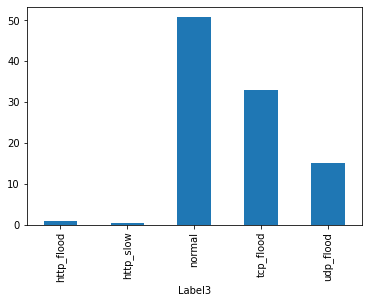

In [9]:
import matplotlib.pyplot as plt

Q4.plot(kind="bar")
plt.show()

In [10]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml
data = data.withColumn("ip_proto", data["ip_proto"] * 1000).withColumnRenamed(
    "ip_proto", "ip_proto_int"
)
# Multiplicamos por 1000 para obtener los valores correctos de los protocolos, 17 para UDP y 6 para TCP.
data.select(data["ip_proto_int"]).distinct().show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [11]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean)
# de bytes transmitidos agrupados por protocolo
Q6 = data.groupby("ip_proto_int").sum("ip_len_mean")
Q6.show()
# Agrupamos por protocolo y sumamos por la columna de longitud media.

+------------+-----------------+
|ip_proto_int| sum(ip_len_mean)|
+------------+-----------------+
|        17.0|7064.346040678179|
|         6.0| 26867.1914740567|
+------------+-----------------+



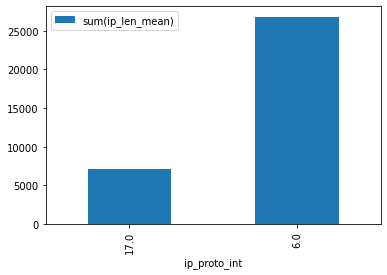

In [12]:
Q6.toPandas().set_index(["ip_proto_int"]).plot(kind="bar")
plt.show()

In [13]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
Q7 = (
    data.filter(data["ip_proto_int"] == 17)
    .groupby("label1")
    .sum("ip_len_mean")
    .orderBy("sum(ip_len_mean)", ascending=False)
)
Q7.show()
# Filtramos por el protocolo 17 correspondiente a UDP.
# Agrupamos por los tipos de trafico en 'label1' y sumamos por la columna de longitud media de paquete.
# Por último ordenamos de mayor a menor.
# Vemos que el tráfico total debido a ataques 'udp_flood' es sustancialmente mayor al tráfico normal.

+---------+------------------+
|   label1|  sum(ip_len_mean)|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



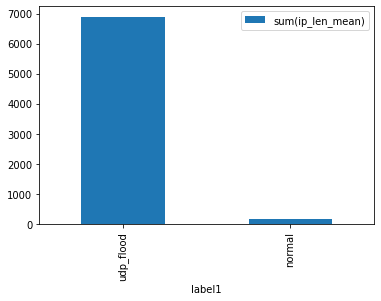

In [14]:
Q7.toPandas().set_index(["label1"]).plot(kind="bar")
plt.show()

In [15]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
Q8 = (
    data.filter(data["ip_proto_int"] == 6)
    .groupby("label1")
    .sum("ip_len_mean")
    .orderBy("sum(ip_len_mean)", ascending=False)
)
Q8.show()
# Filtramos por el protocolo 6 correspondiente a TCP.
# Agrupamos por los tipos de trafico en 'label1' y sumamos por la columna de longitud media de paquete.
# Por último ordenamos de mayor a menor.
# Vemos que el tráfico total debido al tráfico normal es el más alto para este protocolo, seguido de los ataques tipo flood y luego slow.

+-----------------+------------------+
|           label1|  sum(ip_len_mean)|
+-----------------+------------------+
|           normal|11615.053998509025|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_ack_flood|            2000.0|
|    tcp_fin_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



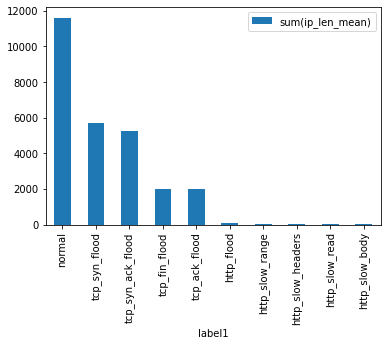

In [16]:
Q8.toPandas().set_index(["label1"]).plot(kind="bar")
plt.show()

# PARTE 2: Uso de Spark para análisis de datos, Spark SQL #

Contestar a las cuestiones anteriores empleando Spark SQL

In [17]:
data = spark.read.csv(
    "../RecursosdelTema2.2/dataset_descriptor.csv",
    mode="DROPMALFORMED",
    inferSchema=True,
    header=True,
)

In [18]:
# Crear la vista en memoria y añadir una celda por cada cuestión que se debe responder
data.registerTempTable("data")

In [19]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?

spark.sql(
    """
    SELECT DISTINCT label1 
    FROM data
    """
).show()

+-----------------+
|           label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [20]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?

spark.sql(
    """
    SELECT DISTINCT label3 
    FROM data
    """
).show()

+----------+
|    label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [21]:
# Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.

spark.sql(
    """
    WITH
    total_t AS (
        SELECT count(label3) total
        FROM data),
   fitered_t AS(
        SELECT count(label3) filtered
        FROM data
        WHERE label3 != 'normal')
    SELECT ROUND(filtered*100/total, 2) percentage
    FROM total_t, fitered_t     
    """
).show()

+----------+
|percentage|
+----------+
|     49.26|
+----------+



In [22]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)

Q4 = spark.sql(
    """
    WITH
    total_t AS (
        SELECT count(label3) total
        FROM data),
    fitered_t AS (
        SELECT label3, count(label3) filtered
        FROM data
        GROUP BY label3)
    SELECT label3 as trafic, ROUND(filtered*100/total, 4) percentage
    FROM total_t, fitered_t     
    """
)
Q4.show()

+----------+----------+
|    trafic|percentage|
+----------+----------+
|http_flood|    0.7626|
| tcp_flood|   32.9407|
|    normal|   50.7429|
| udp_flood|   15.1516|
| http_slow|    0.4022|
+----------+----------+



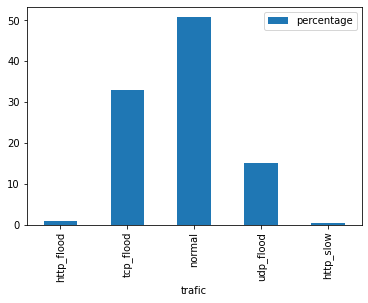

In [23]:
Q4.toPandas().set_index(["trafic"]).plot(kind="bar")
plt.show()

In [24]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

spark.sql(
    """
    SELECT DISTINCT ip_proto * 1000 ip_proto_int
    FROM data  
    """
).show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [25]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean)
# de bytes transmitidos agrupados por protocolo

Q6 = spark.sql(
    """
    SELECT ip_proto * 1000 ip_proto_int, SUM(ip_len_mean) trafico_total
    FROM data 
    GROUP BY ip_proto_int
    """
)
Q6.show()

+------------+-----------------+
|ip_proto_int|    trafico_total|
+------------+-----------------+
|        17.0|7064.346040678179|
|         6.0| 26867.1914740567|
+------------+-----------------+



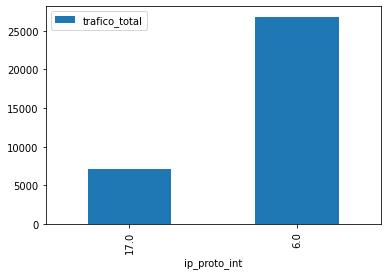

In [26]:
Q6.toPandas().set_index(["ip_proto_int"]).plot(kind="bar")
plt.show()

In [27]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor

Q7 = spark.sql(
    """
    SELECT label1, SUM(ip_len_mean) trafico_total
    FROM data
    WHERE ip_proto * 1000 = 17
    GROUP BY label1
    ORDER BY trafico_total DESC
    """
)
Q7.show()

+---------+------------------+
|   label1|     trafico_total|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



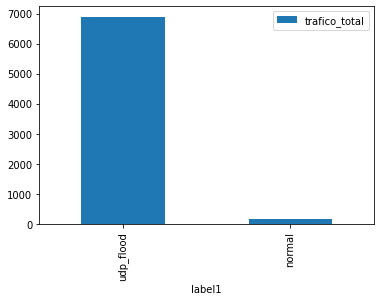

In [28]:
Q7.toPandas().set_index(["label1"]).plot(kind="bar")
plt.show()

In [29]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
Q8 = spark.sql(
    """
    SELECT label1, SUM(ip_len_mean) trafico_total
    FROM data
    WHERE ip_proto * 1000 = 6
    GROUP BY label1
    ORDER BY trafico_total DESC
    """
)
Q8.show()

+-----------------+------------------+
|           label1|     trafico_total|
+-----------------+------------------+
|           normal|11615.053998509025|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



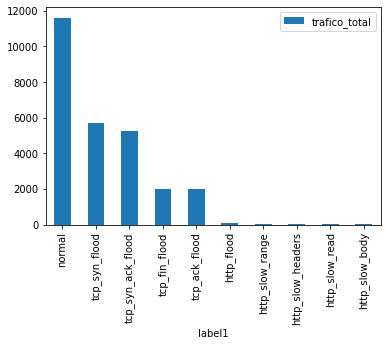

In [30]:
Q8.toPandas().set_index(["label1"]).plot(kind="bar")
plt.show()